In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib as mpl

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

from itertools import product

from tqdm import tqdm

plt.rcParams.update({'figure.figsize': (15, 7), 'figure.dpi': 120})

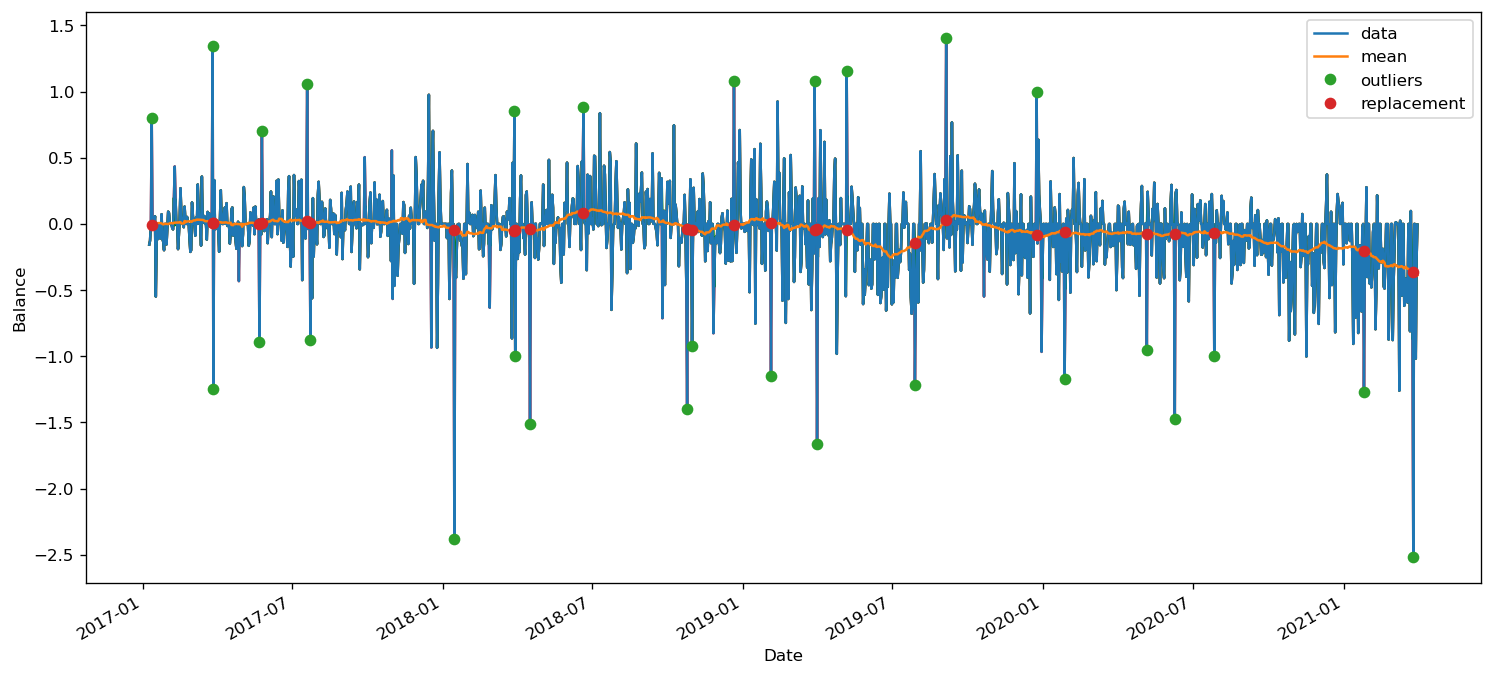

In [13]:
df = pd.read_excel("/home/owner/Documents/DEV/Time_series/Project 1_2024.xlsx", parse_dates=['Date'], index_col='Date', usecols=['Balance', 'Date'])

start_date = df.index[0]
threshold_date = np.datetime64('2019-07-30')
end_date = df.index[-1]#np.datetime64('2020-09-11')

mask_before = (df.index < threshold_date) & (df.index >= start_date)
mask_after = (df.index >= threshold_date) & (df.index <= end_date)

# избавление от выбросов, графики ес че уберешь

def zscore(s, window, thresh=3, return_all=False):
    roll = s.rolling(window=window, min_periods=1, center=True)
    avg = roll.mean()
    std = roll.std(ddof=0)
    z = s.sub(avg).div(std)
    m = z.between(-thresh, thresh)

    if return_all:
        return z, avg, std, m
    return s.where(m, avg)

Balance_balanced = zscore(df.Balance, window=50)

sns.lineplot(df.Balance, color='red')
sns.lineplot(Balance_balanced, color='green')

z, avg, std, m = zscore(df.Balance, window=70, return_all=True)

ax = plt.subplot()

df.Balance.plot(label='data')
avg.plot(label='mean')
df.loc[~m, 'Balance'].plot(label='outliers', marker='o', ls='')
avg[~m].plot(label='replacement', marker='o', ls='')
plt.legend()

df.Balance = Balance_balanced

USD_RUB_df = pd.read_csv(
    "/home/owner/Documents/DEV/Time_series/USD_RUB.csv",
    index_col='Дата',
    parse_dates=['Дата'],
    usecols=['Дата', 'Цена'],
    )

USD_RUB_df.rename(columns={'Цена' : 'USD'}, inplace=True)

new_df = df.join(USD_RUB_df)
while not new_df.USD.notna().all():
    new_df.fillna(new_df.shift(1), inplace=True)
new_df.USD = new_df.USD.str.replace(',', '.').astype(float)


GDP = {2016: 1.28, 2017: 1.57, 2018: 1.66, 2019: 1.69, 2020: 1.49, 2021: 1.84} # in trillions

new_df['last_year_GDP'] = (new_df.index.year - 1)
new_df['last_year_GDP'] = new_df['last_year_GDP'].apply(lambda x: GDP[x])

GDP = pd.read_excel("/home/owner/Documents/DEV/Time_series/VVP_kvartal_s 1995-2023.xlsx", "2")[2:]
GDP = GDP.iloc[1]

offset = 4 * (2016-2011)
GDP = GDP[offset:]

new_df['quartal'] = new_df.index.month // 4 + 1
new_df['quartal'] = (new_df.index.year - 2016)*4 + new_df['quartal']

new_df['GDP_by_prev_quartal'] = new_df['quartal'].apply(lambda quartal: GDP[quartal - 2])

new_df.drop(columns='quartal', inplace=True)

keyRates = pd.read_csv('/home/owner/Documents/DEV/Time_series/KeyRate.csv', header=None, names=['dates', 'rates'],  sep=';', index_col='dates')
keyRates.index = pd.to_datetime(keyRates.index)
keyRates.sort_index(inplace=True)
new_df['key_rate'] = new_df.index.to_series().apply(lambda date: keyRates.rates[keyRates.index <= date][-1])

import holidays

all_holidays = pd.to_datetime(np.fromiter(holidays.RU(years=[2017, 2018, 2019, 2020, 2021]).keys(), 'datetime64[ns]'))
new_df['holiday'] = new_df.index.isin(all_holidays).astype(int)

bool_holiday = new_df.holiday.astype(bool)
new_df['week_before_holiday'] = bool_holiday.shift(-1).fillna(0)| \
    bool_holiday.shift(-2).fillna(0) | bool_holiday.shift(-3).fillna(0) | \
    bool_holiday.shift(-4).fillna(0) | bool_holiday.shift(-5).fillna(0) | \
    bool_holiday.shift(-6).fillna(0) | bool_holiday.shift(-7).fillna(0)
new_df.week_before_holiday = new_df.week_before_holiday.astype(int)

new_df['day_before_holiday'] = new_df.holiday.shift(-1).fillna(0).astype(int)
new_df['spring'] = new_df.index.month.isin([3,4,5]).astype(int)
new_df['summer'] = new_df.index.month.isin([6,7,8]).astype(int)
new_df['autumn'] = new_df.index.month.isin([9,10,11]).astype(int)
new_df['winter'] = new_df.index.month.isin([12,1,2]).astype(int)

new_df['weekdays'] = new_df.index.day_name()
new_df = new_df.join(new_df['weekdays'].str.get_dummies()).drop(columns='weekdays')
for weekday in new_df.index.day_name().unique(): new_df[weekday] = new_df[weekday].astype(int)

new_df['month'] = new_df.index.month_name()
new_df = new_df.join(new_df['month'].str.get_dummies()).drop(columns='month')


In [14]:


months = new_df.index.month_name().unique()
new_df['avg_Balance_by_this_month'] = 0
for month in months:
    mask = new_df[month].astype(bool)
    new_df[mask]['avg_Balance_by_this_month'] = new_df[mask]['Balance'].mean()

new_df['weekend'] = (new_df.Saturday | new_df.Sunday).astype(int)

mask = new_df.weekend.astype(bool)
new_df[mask]['avg_Balance_weekend'] = new_df[mask | mask_before]['Balance'].mean()

seasons = ['winter', 'spring', 'summer', 'autumn']
new_df['avg_Balance_by_season'] = 0
for season in seasons:
    mask = new_df[season].astype(bool)
    new_df[mask]['avg_Balance_by_season'] = new_df[mask | mask_before]['Balance'].mean()

new_df[mask | mask_before]['avg_Balance_by_week_of_month'] = 0

mask = new_df.index.day <= 7
new_df[mask]['avg_Balance_by_week_of_month'] = new_df[mask | mask_before]['Balance'].mean()
mask = (new_df.index.day >= 8) & (new_df.index.day <= 14)
new_df[mask]['avg_Balance_by_week_of_month'] = new_df[mask | mask_before]['Balance'].mean()
mask = (new_df.index.day >= 15) & (new_df.index.day <= 21)
new_df[mask]['avg_Balance_by_week_of_month'] = new_df[mask | mask_before]['Balance'].mean()
mask = new_df.index.day >= 22
new_df[mask]['avg_Balance_by_week_of_month'] = new_df[mask | mask_before]['Balance'].mean()

new_df['even_year'] = (~(new_df.index.year % 2).astype(bool)).astype(int)

new_df['avg_Balance_by_day'] = 0
for week_day in new_df.index.day_name():
    mask = new_df[week_day].astype(bool)
    new_df[mask]['avg_Balance_by_season'] = new_df[mask | mask_before]['Balance'].mean()

new_df[mask]['avg_Balance_by_quartal'] = 0

mask = new_df.index.month.isin([1,2,3])
new_df[mask]['avg_Balance_by_quartal'] = new_df[mask | mask_before]['Balance'].mean()
mask = new_df.index.month.isin([4,5,6])
new_df[mask]['avg_Balance_by_quartal'] = new_df[mask | mask_before]['Balance'].mean()
mask = new_df.index.month.isin([7,8,9])
new_df[mask]['avg_Balance_by_quartal'] = new_df[mask | mask_before]['Balance'].mean()
mask = new_df.index.month.isin([10,11,12])
new_df[mask]['avg_Balance_by_quartal'] = new_df[mask | mask_before]['Balance'].mean()

new_df['tax_day'] = new_df.index.day.isin([28]).astype(int)

exp_smoothing = [new_df.Balance.iloc[0]]

alpha = 0.2

for i in range(1, len(new_df)):
    exp_smoothing.append(alpha * new_df.Balance.iloc[i] + (1 - alpha) * exp_smoothing[i - 1])

new_df['exp_smoothing'] = exp_smoothing

def rolling_window_stats(window_size):
    new_df[f'min_last_{window_size}'] = new_df.Balance.rolling(7).min().shift(1)
    new_df[f'max_last_{window_size}'] = new_df.Balance.rolling(7).max().shift(1)
    new_df[f'mean_last_{window_size}'] = new_df.Balance.rolling(7).mean().shift(1)

    last_min = np.inf
    last_max = - np.inf
    sum = 0

    new_df[f'min_last_{window_size}'].iloc[0] = 0
    new_df[f'max_last_{window_size}'].iloc[0] = 0
    new_df[f'mean_last_{window_size}'].iloc[0] = 0

    for i in range(1,window_size):
        if last_min > new_df.Balance.iloc[i-1]:
            last_min = new_df.Balance.iloc[i-1]
        new_df[f'min_last_{window_size}'].iloc[i] = last_min

        if last_max < new_df.Balance.iloc[i-1]:
            last_max = new_df.Balance.iloc[i-1]
        new_df[f'max_last_{window_size}'].iloc[i] = last_max

        sum += new_df.Balance.iloc[i-1]
        new_df[f'mean_last_{window_size}'].iloc[i] = sum / i

rolling_window_stats(7)
rolling_window_stats(14)
rolling_window_stats(21)
rolling_window_stats(28)
rolling_window_stats(31)

n_shifts = 8
for i in range(1, n_shifts+1):
    new_df[f'shift_{i}'] = new_df.Balance.shift(i)
new_df = new_df[n_shifts:]

# финальное обновление масок! БЕЗ НЕГО СТРЕЛЬНЕТ БЛОК БУСТИНГА
mask_before = (new_df.index < threshold_date) & (new_df.index >= start_date)
mask_after = (new_df.index >= threshold_date) & (new_df.index <= end_date)

exog = list(filter(lambda column: column != 'Balance' and not column.startswith("shift"), new_df.columns))


In [15]:
# new_df.USD = new_df.USD.str.replace(',', '.').astype(float)
new_df.USD = new_df.USD.shift(1)

In [16]:
# keyRates = pd.read_csv('/home/owner/Documents/DEV/Time_series/KeyRate.csv', header=None, names=['dates', 'rates'],  sep=';', index_col='dates')
keyRates.index = pd.to_datetime(keyRates.index)
keyRates.sort_index(inplace=True)
new_df['key_rate'] = new_df.index.to_series().apply(lambda date: keyRates.rates[keyRates.index < date][-1])
# здесь уже со сдвигом

In [17]:
exp_smoothing = [new_df.Balance.iloc[0]]

alpha = 0.2

for i in range(1, len(new_df)):
    exp_smoothing.append(alpha * new_df.Balance.iloc[i] + (1 - alpha) * exp_smoothing[i - 1])

new_df['exp_smoothing'] = exp_smoothing
new_df.exp_smoothing = new_df.exp_smoothing.shift(1)


In [18]:
pip install pactools

Note: you may need to restart the kernel to use updated packages.


In [19]:
from xgboost import XGBRegressor


X = new_df.drop(columns=['Balance'])
y = new_df.Balance

X_train, X_test = X[mask_before], X[mask_after]
y_train, y_test = y[mask_before], y[mask_after]

param_grid_XGB = [
    {
        'n_estimators' : [1000, 1700, 2400, 3000],
        'learning_rate' : [.1, .3, .5, .9],
        'max_depth': [3, 6, 12],
        'min_child_weight': [1, 3, 5, 10],
        'grow_policy': ['depthwise', 'losswise'],
        'objective': ['reg:absoluteerror']
     },
    {
        'n_estimators' : [300, 1000],
        'learning_rate' : [.1, .3, .5, .9],
        'quantile_alpha' : [0.09] + list(np.logspace(-5, 0, 10, endpoint=True)),
        'max_depth': [3, 6, 12],
        'min_child_weight': [1, 3, 5, 10],
        'grow_policy': ['depthwise', 'losswise'],
        'objective': ['reg:quantileerror']
     }
]


from sklearn.model_selection import GridSearchCV
from pactools.grid_search import GridSearchCVProgressBar

import sys
from tqdm.notebook import tqdm
import time
# from tqdm import tqdm if not in notebook
# https://datascience.stackexchange.com/questions/114060/progress-bar-for-gridsearchcv
def fit(model, *args, **kwargs):
    class BarStdout:
        def write(self, text):
            if "totalling" in text and "fits" in text:
                self.bar_size = int(text.split("totalling")[1].split("fits")[0][1:-1])
                self.bar = tqdm(range(self.bar_size))
                self.count = 0
                return
            if "CV" in text and hasattr(self,"bar"):
                self.count += 1
                self.bar.update(n=self.count-self.bar.n)
                if self.count%(self.bar_size//10)==0:
                    time.sleep(0.1)
        def flush(self, text=None):
            pass
    default_stdout= sys.stdout
    sys.stdout = BarStdout()
    model.verbose = 10
    model.fit(*args, **kwargs)
    sys.stdout = default_stdout
    return model


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


gridXGB = GridSearchCVProgressBar(XGBRegressor(),
                       param_grid_XGB,
                       scoring='neg_mean_absolute_error',
                       cv=5).fit(X_train, y_train)
modelXGB = fit(gridXGB, X_train, y_train)

print(modelXGB.best_params_)

  0%|          | 0/12480 [00:00<?, ?it/s]

{'grow_policy': 'depthwise', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 1000, 'objective': 'reg:absoluteerror'}


mean err XGB = 0.15822858998818226
max err XGB = 1.1390192513063273


<Axes: xlabel='Date', ylabel='Balance'>

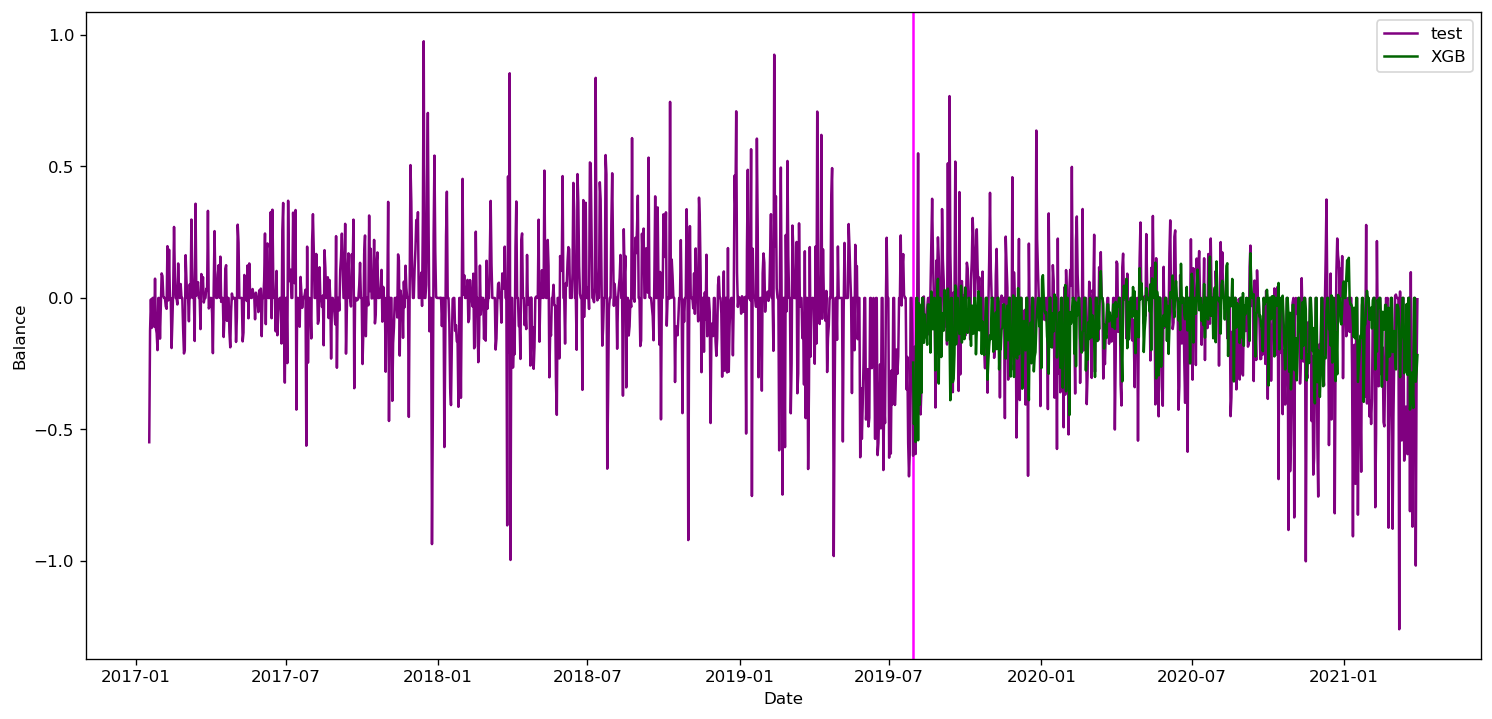

In [20]:
modelXGB = XGBRegressor(grow_policy='depthwise', learning_rate= 0.5, max_depth=3, min_child_weight=10, n_estimators=1000, objective='reg:quantileerror', quantile_alpha = 0.2782559402207126).fit(X_train, y_train)

predictXGB = modelXGB.predict(X_test)


print(f"mean err XGB = {(new_df.Balance[mask_after]-predictXGB).abs().mean()}")
print(f"max err XGB = {(new_df.Balance[mask_after]-predictXGB).abs().max()}")

plt.axvline(x=threshold_date, color='magenta')
sns.lineplot(x=new_df.index, y=new_df.Balance, label='test', color = 'purple')
sns.lineplot(x=new_df.index[mask_after], y=predictXGB, label='XGB', color='darkgreen')


In [21]:
X.columns

Index(['USD', 'last_year_GDP', 'GDP_by_prev_quartal', 'key_rate', 'holiday',
       'week_before_holiday', 'day_before_holiday', 'spring', 'summer',
       'autumn', 'winter', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', 'April', 'August', 'December',
       'February', 'January', 'July', 'June', 'March', 'May', 'November',
       'October', 'September', 'avg_Balance_by_this_month', 'weekend',
       'avg_Balance_by_season', 'even_year', 'avg_Balance_by_day', 'tax_day',
       'exp_smoothing', 'min_last_7', 'max_last_7', 'mean_last_7',
       'min_last_14', 'max_last_14', 'mean_last_14', 'min_last_21',
       'max_last_21', 'mean_last_21', 'min_last_28', 'max_last_28',
       'mean_last_28', 'min_last_31', 'max_last_31', 'mean_last_31', 'shift_1',
       'shift_2', 'shift_3', 'shift_4', 'shift_5', 'shift_6', 'shift_7',
       'shift_8'],
      dtype='object')